# Predicting Brain-State Using Spatio-Temporal GNNs

In this notebook, we train various spatio-temporal graph neural networks to predict the brain state of a single participant based on their brain activity (captured by collecting 10 minute fMRI data).

### Install all necessary packages

In [ ]:
import os
import torch

torch_version = str(torch.__version__)
! pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00


In [ ]:
! git clone https://github.com/GusStgoReyes/stgnnbrain.git

Cloning into 'stgnnbrain'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 216 (delta 4), reused 216 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (216/216), 192.54 KiB | 1.60 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Filtering content: 100% (184/184), 97.56 MiB | 6.81 MiB/s, done.


In [ ]:
%cd stgnnbrain/
%mkdir output
%mkdir output/model
%mkdir output/splits
%mkdir output/results

/content/stgnnbrain


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset loading and Graph creation

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch_geometric
from torch_geometric.data import Data, Dataset

In [ ]:
def load_connectivity_data(subject_ids, data_path):
    """
    Load connectivity matrices for given subjects from the specified path.

    Inputs:
      subject_ids (list): List of subject IDs.
      data_path (str): Path to the directory containing connectivity matrices.

    Outputs:
      conn_matrices (dict): Dictionary of connectivity matrices with subject IDs as keys.
    """
    conn_matrices = {}
    for subject_id in subject_ids:
        file_name = f'{subject_id}.txt'
        file_path = os.path.join(data_path, file_name)

        if os.path.exists(file_path):
            # Load the connectivity matrix, skipping the first row and column
            matrix = np.loadtxt(file_path, dtype='str', delimiter=',')[1:, 1:]
            # Convert the matrix to float32
            matrix = matrix.astype(np.float32)
            # Convert the matrix to a PyTorch tensor and store it in the dictionary
            conn_matrices[subject_id] = torch.FloatTensor(matrix)
        else:
            raise ValueError(f"Missing connectivity data for subject {subject_id}")

    return conn_matrices

In [ ]:
def load_timeseries_data(subject_ids, data_path):
    """
    Load time series data for given subjects from the specified path.

    Inputs:
      subject_ids (list): List of subject IDs.
      data_path (str): Path to the directory containing time series data.

    Outputs:
      timeseries_data (dict): Dictionary of time series data with subject IDs as keys.
    """
    timeseries_data = {}
    for subject_id in subject_ids:
        file_name = f'{subject_id}.txt'
        file_path = os.path.join(data_path, file_name)

        if os.path.exists(file_path):
            # Load the time series data
            timeseries = np.loadtxt(file_path, dtype='str', delimiter=',')[1:, 1:]
            # Convert the time series data to float32
            timeseries = timeseries.astype(np.float32)
            # Convert the time series data to a PyTorch tensor and store it in the dictionary
            timeseries_data[subject_id] = torch.FloatTensor(timeseries)
        else:
            raise ValueError(f"Missing time series data for subject {subject_id}")

    return timeseries_data

In [ ]:
def load_labels(labels_path):
    """
    Load labels from a CSV file.

    Inputs:
      labels_path (str): Path to the labels.csv file.

    Outputs:
      labels (dict): Dictionary of labels with subject IDs as keys.
    """
    labels = {}

    # Read the CSV file into a DataFrame
    labels_df = pd.read_csv(labels_path)
    # Iterate over each row in the DataFrame
    for _, row in labels_df.iterrows():
        subject_id = row['subcode']
        label = row['caffeinated']
        # Store the label in the dictionary with the subject ID as the key
        labels[subject_id] = label

    return labels

In [ ]:
class ConnectomeDataset(Dataset):
    """
    For each subject, creates a graph where the nodes are the Brain ROIs and the features are the time points.
    The connectivity matrix is the correlation coefficient between the time
    series data of two Brain ROIs. We only include the edges with absolute correlation
    greater than 0.1. Furthermore, we keep the edge attributes as the absolute value of the
    correlation coefficient.
    """
    def __init__(self, connectivity_matrices, timeseries_matrices, labels, corr_threshold=0.1):
        super().__init__()
        self.connectivity_matrices = connectivity_matrices
        self.timeseries_matrices = timeseries_matrices
        self.subject_ids = list(labels.keys())
        self.labels = labels
        self.corr_threshold = corr_threshold

        # Sort the subject IDs for consistent ordering
        self.subject_ids.sort()

    def len(self):
        """
        Return the number of subjects in the dataset.
        """
        return len(self.subject_ids)

    def get(self, idx):
        """
        Get the data for a specific subject by index.

        Inputs:
          idx (int): Index of the subject.

        Outputs:
          data (Data): PyTorch Geometric Data object containing the graph and label.
        """
        subject_id = self.subject_ids[idx]
        # Convert adjacency matrix to edge_index and edge_attr
        adj_matrix = torch.abs(self.connectivity_matrices[subject_id])
        edge_index = (adj_matrix > self.corr_threshold).nonzero().t()
        edge_attr = adj_matrix[edge_index[0], edge_index[1]].unsqueeze(1)

        # Create a PyTorch Geometric Data object
        data = Data(x=self.timeseries_matrices[subject_id].T,
                    edge_index=edge_index,
                    edge_attr=edge_attr)
        data.y = torch.tensor([self.labels[subject_id]], dtype=torch.long)

        return data

In [ ]:
class ConnectomeDataset_TimeNodes(Dataset):
    """
        For each subject, creates a graph where the nodes are the time points and the features are the value at the ROIs.
        The connectivity matrix is the correlation coefficient between the ROI values between two different time points.
        We only include the edges with absolute correlation greater than 0.1. Furthermore, we keep the edge attributes as the
        absolute value of the correlation coefficient.
    """
    def __init__(self, timeseries_matrices, labels, timepoints=100, corr_threshold=0.1):
        super().__init__()
        self.timepoints = timepoints
        self.timeseries_matrices = timeseries_matrices
        self.subject_ids = list(labels.keys())
        self.labels = labels
        self.corr_threshold = corr_threshold

        # Sort the subject IDs for consistent ordering
        self.subject_ids.sort()

    def get_connectivity_matrix(self, timeseries):
        """
        Compute the connectivity matrix for the given time series data.

        Inputs:
          timeseries (Tensor): Time series data for a subject.

        Outputs:
          corr_matrix (Tensor): Correlation matrix of the time series data.
        """
        # timeseries will be a num_nodes x timepoints array
        # create a timepoints x timepoints array of correlation coefficient
        corr_matrix = torch.corrcoef(timeseries)
        return corr_matrix

    def len(self):
        """
        Return the number of subjects in the dataset.
        """
        return len(self.subject_ids)

    def get(self, idx):
        """
        Get the data for a specific subject by index.

        Inputs:
          idx (int): Index of the subject.

        Outputs:
          data (Data): PyTorch Geometric Data object containing the graph and label.
        """
        subject_id = self.subject_ids[idx]
        timeseries = self.timeseries_matrices[subject_id][:self.timepoints, :]
        # Compute the connectivity matrix
        adj_matrix = torch.abs(self.get_connectivity_matrix(timeseries))
        edge_index = (adj_matrix > self.corr_threshold).nonzero().t()
        edge_attr = adj_matrix[edge_index[0], edge_index[1]].unsqueeze(1)

        # Create a PyTorch Geometric Data object
        data = Data(x=timeseries,
                    edge_index=edge_index,
                    edge_attr=edge_attr)
        data.y = torch.tensor([self.labels[subject_id]], dtype=torch.long)

        return data

In [ ]:
# CHANGE THIS TO RUN!!
data_pth = '/content/drive/MyDrive/CS224W Project/data'

# Load labels
labels = load_labels(os.path.join(data_pth, 'labels.csv'))
subject_ids = list(labels.keys())
print(f'Class distribution: {np.unique(list(labels.values()), return_counts=True)}')
print('-' * 50)

# Load connectivity matrices and subject IDs
connectivity_matrices = load_connectivity_data(subject_ids, os.path.join(data_pth, 'connectivity_aa116'))
print(f'Number of samples: {len(connectivity_matrices)}')
print(f'Number of ROIs: {connectivity_matrices[list(connectivity_matrices)[0]].shape[0]}')
print(connectivity_matrices.keys())

# Load timeseries matrices
timeseries_matrices = load_timeseries_data(subject_ids, os.path.join(data_pth, 'timeseries_aa116'))
print(f'Number of timeseries matrices: {len(timeseries_matrices)}')

# Initialize datasets
dataset = ConnectomeDataset(connectivity_matrices, timeseries_matrices, labels)
dataset_time = ConnectomeDataset_TimeNodes(timeseries_matrices, labels, timepoints = 100)

Class distribution: (array([0, 1]), array([40, 32]))
--------------------------------------------------
Number of samples: 72
Number of ROIs: 116
dict_keys(['sub014', 'sub016', 'sub017', 'sub019', 'sub020', 'sub022', 'sub023', 'sub025', 'sub026', 'sub028', 'sub029', 'sub032', 'sub035', 'sub037', 'sub038', 'sub039', 'sub040', 'sub042', 'sub043', 'sub045', 'sub047', 'sub048', 'sub050', 'sub051', 'sub054', 'sub056', 'sub057', 'sub058', 'sub059', 'sub060', 'sub061', 'sub062', 'sub063', 'sub064', 'sub065', 'sub066', 'sub067', 'sub068', 'sub069', 'sub070', 'sub071', 'sub072', 'sub073', 'sub074', 'sub075', 'sub076', 'sub077', 'sub078', 'sub079', 'sub080', 'sub081', 'sub082', 'sub083', 'sub084', 'sub085', 'sub086', 'sub087', 'sub088', 'sub089', 'sub091', 'sub092', 'sub094', 'sub095', 'sub096', 'sub097', 'sub098', 'sub099', 'sub100', 'sub101', 'sub102', 'sub103', 'sub104'])
Number of timeseries matrices: 72


### Models architectures

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

#### Baseline models

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()

        # Define the input size
        self.input_size = input_size

        # Define hidden layers
        self.hidden_layers = nn.ModuleList()
        in_features = input_size * input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(in_features, hidden_size))
            in_features = hidden_size

        # Define the output layer
        self.output_layer = nn.Linear(in_features, output_size)

    def forward(self, node_features, edge_index, edge_attributes):
        """
        Forward pass for the MLP model.

        Inputs:
          node_features (Tensor): Node features.
          edge_index (Tensor): Edge indices.
          edge_attributes (Tensor): Edge attributes.

        Outputs:
          output (Tensor): Output of the MLP model.
        """
        device = node_features.device

        # Initialize an adjacency matrix with zeros
        adjacency_matrix = torch.zeros(self.input_size, self.input_size).to(device)
        # Fill the adjacency matrix with edge attributes
        adjacency_matrix[edge_index[0], edge_index[1]] = edge_attributes[:, 0]

        # Flatten the adjacency matrix
        x = adjacency_matrix.flatten()

        # Pass through hidden layers
        for layer in self.hidden_layers:
            x = F.relu(layer(x))  # Apply ReLU activation after each hidden layer

        # Pass through the output layer and unsqueeze the output
        output = self.output_layer(x).unsqueeze(0)  # No activation on the final layer (for raw output)

        return output

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Define the output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, node_features, edge_index, edge_attributes):
        """
        Forward pass for the SimpleLSTM model.

        Inputs:
          node_features (Tensor): Time series data of shape (input_size, seq_len).
          edge_index (Tensor): Edge indices.
          edge_attributes (Tensor): Edge attributes.

        Outputs:
          output (Tensor): Output of the SimpleLSTM model.
        """
        x = node_features.T
        # Pass the time series data through the LSTM layer
        x, _ = self.lstm(x.unsqueeze(0))  # Output for all time steps

        # Use the last time step's output
        x = x[:, -1, :]
        x = F.relu(x)  # Apply ReLU activation

        # Pass through the output layer
        x = self.output_layer(x)

        return x

In [ ]:
class StaticGCN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, num_nodes=116):
        super(StaticGCN, self).__init__()

        # Define the input channels and number of nodes
        self.input_channels = input_channels
        self.num_nodes = num_nodes

        # Define the first GCN layer
        self.conv1 = GCNConv(input_channels, hidden_channels)
        # Define the second GCN layer
        self.conv2 = GCNConv(hidden_channels, output_channels)

    def forward(self, node_features, edge_index, edge_attributes):
        """
        Forward pass for the StaticGCN model.

        Inputs:
          node_features (Tensor): Node features.
          edge_index (Tensor): Edge indices.
          edge_attributes (Tensor): Edge attributes.

        Outputs:
          output (Tensor): Output of the StaticGCN model.
        """
        device = node_features.device

        # Initialize node features with ones
        x = torch.ones((self.num_nodes, self.input_channels)).to(device)

        # Apply the first GCN layer with edge attributes
        x = self.conv1(x, edge_index, edge_weight=edge_attributes)
        x = F.relu(x)

        # Apply the second GCN layer with edge attributes
        x = self.conv2(x, edge_index, edge_weight=edge_attributes)

        # Apply global mean pooling
        output = global_mean_pool(x, None)

        return output

#### Graph 1 models

In [ ]:
class CNNGCN(nn.Module):
    def __init__(self, hidden_channels, out_channels, num_timepoints = 518, window_size=32, stride = 2, dilation = 2, less_layers = False):
        super(CNNGCN, self).__init__()
        self.less_layers = less_layers

        # 1D Convolution to process time series data for each node
        self.conv1d_1 = nn.Conv1d(
                                in_channels=1,  # Input features per time point
                                out_channels=1,  # Output features per time point
                                kernel_size=window_size,
                                stride = stride,
                                dilation = dilation,
                            )
        self.conv1d_2 = nn.Conv1d(
                                in_channels=1, # Input features per time point
                                out_channels=1, # Output features per time point
                                kernel_size=window_size,
                                stride = stride,
                                dilation = dilation,
                            )

        # Compute the output dimension of the Conv1d layers
        conv_output_dim = (num_timepoints - (window_size - 1) * dilation - 1) // stride + 1
        conv_output_dim = (conv_output_dim - (window_size - 1) * dilation - 1) // stride + 1
        in_channels = int(conv_output_dim)

        # Graph Convolution layer
        if self.less_layers:
            self.conv1 = GCNConv(in_channels, out_channels)
        else:
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, node_features, edge_index, edge_attributes):
        """
        Forward pass for the CNNGCN model.

        Inputs:
          node_features (Tensor): Node features.
          edge_index (Tensor): Edge indices.
          edge_attributes (Tensor): Edge attributes.

        Outputs:
          output (Tensor): Output of the CNNGCN model.
        """
        x = node_features.unsqueeze(1)  # Shape: (num_nodes, 1, time_points)

        # Apply the first 1D convolution (temporal information)
        x = self.conv1d_1(x)
        x = F.relu(x)
        # Apply the second 1D convolution
        x = self.conv1d_2(x)
        x = F.relu(x)

        # Reshape the output of the 1D convolution
        x = x.squeeze(1)  # Shape: (num_nodes, time_points_new)

        # Apply GCNConv layers (spatial information)
        if self.less_layers:
           x = self.conv1(x, edge_index, edge_weight=edge_attributes)
        else:
            x = self.conv1(x, edge_index, edge_weight=edge_attributes)
            x = F.relu(x)
            x = self.conv2(x, edge_index, edge_weight=edge_attributes)

        # Apply global mean pooling
        x = global_mean_pool(x, None)

        return x

In [ ]:
class TemporalGCN(nn.Module):
    def __init__(self, hidden_channels, out_channels, less_layers = False, temporal_layer = 'LSTM'):
        super(TemporalGCN, self).__init__()
        self.less_layers = less_layers
        self.hidden_channels = hidden_channels

        if temporal_layer == 'LSTM':
            # LSTM layer to process time series data
            self.temporal_layer = nn.LSTM(input_size = 1, # 1 feature per time point
                                            hidden_size = hidden_channels, # Number of hidden units
                                            batch_first=True)
        elif temporal_layer == 'RNN':
            # RNN layer to process time series data
            self.temporal_layer = nn.RNN(input_size = 1, # 1 feature per time point
                                            hidden_size = hidden_channels, # Number of hidden units
                                            batch_first=True)

        # Graph Convolution layer
        if self.less_layers:
           self.conv1 = GCNConv(hidden_channels, out_channels)
        else:
            self.conv1 = GCNConv(hidden_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, node_features, edge_index, edge_attributes):
        """
        Forward pass for the TemporalGCN model.

        Inputs:
          node_features (Tensor): Node features.
          edge_index (Tensor): Edge indices.
          edge_attributes (Tensor): Edge attributes.

        Outputs:
          output (Tensor): Output of the TemporalGCN model.
        """
        # Reshape input for batched temporal processing (num_nodes x timeseries x 1)
        x = node_features.unsqueeze(-1)

        # Pass all features through the temporal layer in a single batch
        x, _ = self.temporal_layer(x)

        # Extract the last hidden state for each node
        x = x[:, -1, :]
        x = F.relu(x)

        # Apply GCNConv layers (spatial information)
        if self.less_layers:
          x = self.conv1(x, edge_index, edge_weight=edge_attributes)
        else:
          x = self.conv1(x, edge_index, edge_weight=edge_attributes)
          x = F.relu(x)
          x = self.conv2(x, edge_index, edge_weight=edge_attributes)

        # Global mean pooling
        x = global_mean_pool(x, None)

        return x

In [ ]:
class TemporalGAT(nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=3, less_layers = False, temporal_layer = 'LSTM'):
        super(TemporalGAT, self).__init__()
        self.less_layers = less_layers
        self.hidden_channels = hidden_channels

        if temporal_layer == 'LSTM':
            # LSTM layer to process time series data
            self.temporal_layer = nn.LSTM(input_size = 1, # 1 feature per time point
                                            hidden_size = hidden_channels, # Number of hidden units
                                            batch_first=True)
        elif temporal_layer == 'RNN':
            # RNN layer to process time series data
            self.temporal_layer = nn.RNN(input_size = 1, # 1 feature per time point
                                            hidden_size = hidden_channels, # Number of hidden units
                                            batch_first=True)

        # Graph Convolution layer
        if self.less_layers:
           self.conv1 = GATConv(hidden_channels, out_channels, heads = heads)
        else:
            self.conv1 = GCNConv(hidden_channels, hidden_channels)
            self.conv2 = GATConv(hidden_channels, out_channels, heads = heads)

    def forward(self, node_features, edge_index, edge_attributes, return_attention_weights = False):
        """
        Forward pass for the TemporalGCN model.

        Inputs:
          node_features (Tensor): Node features.
          edge_index (Tensor): Edge indices.
          edge_attributes (Tensor): Edge attributes.

        Outputs:
          output (Tensor): Output of the TemporalGCN model.
        """
        # Reshape input for batched temporal processing (num_nodes x timeseries x 1)
        x = node_features.unsqueeze(-1)

        # Pass all features through the temporal layer in a single batch
        x, _ = self.temporal_layer(x)

        # Extract the last hidden state for each node
        x = x[:, -1, :]
        x = F.relu(x)

        # Apply spatial layers (spatial information)
        if self.less_layers:
          x, (edges, attnt_coeff) = self.conv1(x, edge_index, return_attention_weights = True)
        else:
          x = self.conv1(x, edge_index, edge_weight=edge_attributes)
          x = F.relu(x)
          x, (edges, attnt_coeff) = self.conv2(x, edge_index, return_attention_weights = True)

        # Global mean pooling
        x = global_mean_pool(x, None)

        if return_attention_weights:
          return x, edges, attnt_coeff
        else:
          return x

#### Graph 2 models

In [ ]:
class TimeStaticGCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(TimeStaticGCN, self).__init__()

        # Define the input channels
        self.input_channels = input_channels

        # Define the first GCN layer
        self.conv1 = GCNConv(input_channels, hidden_channels)
        # Define the second GCN layer
        self.conv2 = GCNConv(hidden_channels, output_channels)

    def forward(self, node_features, edge_index, edge_attributes):
        """
        Forward pass for the TimeStaticGCN model.

        Inputs:
          node_features (Tensor): Node features.
          edge_index (Tensor): Edge indices.
          edge_attributes (Tensor): Edge attributes.

        Outputs:
          output (Tensor): Output of the TimeStaticGCN model.
        """
        x = node_features  # (num_timepoints, num_nodes)
        # Apply the first GCN layer with edge attributes
        x = self.conv1(x, edge_index, edge_weight=edge_attributes)
        x = F.relu(x)  # Apply ReLU activation

        # Apply the second GCN layer with edge attributes
        x = self.conv2(x, edge_index, edge_weight=edge_attributes)

        # Apply global mean pooling
        output = global_mean_pool(x, None)

        return output

In [ ]:
class TimeStaticGCNGAT(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, heads = 3):
        super(TimeStaticGCNGAT, self).__init__()

        # Define the input channels
        self.input_channels = input_channels

        # Define the first GCN layer
        self.conv1 = GCNConv(input_channels, hidden_channels)
        # Define the second GCN layer
        self.conv2 = GATConv(hidden_channels, output_channels, heads = heads)

    def forward(self, node_features, edge_index, edge_attributes, return_attention_weights = False):
        """
        Forward pass for the TimeStaticGCN model.

        Inputs:
          node_features (Tensor): Node features.
          edge_index (Tensor): Edge indices.
          edge_attributes (Tensor): Edge attributes.

        Outputs:
          output (Tensor): Output of the TimeStaticGCN model.
        """
        x = node_features  # (num_timepoints, num_nodes)
        # Apply the first GCN layer with edge attributes
        x = self.conv1(x, edge_index, edge_weight=edge_attributes)
        x = F.relu(x)  # Apply ReLU activation

        # Apply the second GCN layer with edge attributes
        x, (edges, attnt_coeff) = self.conv2(x, edge_index, return_attention_weights = True)

        # Apply global mean pooling
        x = global_mean_pool(x, None)

        if return_attention_weights:
          return x, edges, attnt_coeff
        else:
          return x

### Training / Evaluation Helper Functions

In [ ]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=100, min_delta = 0.001, patience = 10):
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            optimizer.zero_grad()
            # Move batch to the device
            batch = batch.to(device)

            # Forward pass
            output = model(batch.x, batch.edge_index, batch.edge_attr)

            # Compute loss
            loss = criterion(output, batch.y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # Early stopping check
        if avg_train_loss < best_train_loss - min_delta:
            best_train_loss = avg_train_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping...')
                break

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {round(avg_train_loss, 3)}')

    return avg_train_loss

In [ ]:
def evaluate(model, val_loader, criterion, device):
    # Switch model to evaluation mode
    model.eval()

    # Placeholders for metrics
    all_true_labels = []
    all_pred_probs = []
    all_pred_labels = []
    val_losses = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            # Forward pass
            output = model(batch.x, batch.edge_index, batch.edge_attr)

            val_loss = criterion(output, batch.y)
            val_losses.append(val_loss.item())

            # Predictions
            val_pred_probs = F.softmax(output, dim=1)
            val_pred_labels = torch.argmax(val_pred_probs, dim=1)

            # Collect outputs
            all_true_labels.append(batch.y.cpu().numpy())
            all_pred_probs.append(val_pred_probs.cpu().numpy())
            all_pred_labels.append(val_pred_labels.cpu().numpy())

    # Aggregate results
    all_true_labels = np.concatenate(all_true_labels, axis=0)
    all_pred_probs = np.concatenate(all_pred_probs, axis=0)
    all_pred_labels = np.concatenate(all_pred_labels, axis=0)

    # Compute metrics
    metrics = calculate_metrics(all_true_labels, all_pred_labels, all_pred_probs)
    avg_val_loss = np.mean(val_losses)

    return avg_val_loss, metrics

In [ ]:
def calculate_metrics(y_true, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_prob[:, 1])
    }

### Train and test the models!

In [ ]:
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Set up the parameters for the model
num_nodes = connectivity_matrices[subject_ids[0]].shape[1]
num_timepoints = timeseries_matrices[subject_ids[0]].shape[0]
num_timepoints_graph2 = 100
hidden_channels = 64
hidden_channels_time = 32
out_channels = 2  # binary classification
window_size = 16
stride = 2
dilation = 2
heads = 3

# Set up parameters for training
patience = 15
min_delta = 0.001
n_splits = 5
num_epochs = 100

In [ ]:
# Training/testing split
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [ ]:
# Define the models
models_roi_graph = {
    'MLP': MLP(num_nodes, [hidden_channels], out_channels),
    'LSTM': SimpleLSTM(num_nodes, hidden_channels, out_channels),
    'StaticGCN' : StaticGCN(hidden_channels, hidden_channels, out_channels, num_nodes = num_nodes),
    'CNNGCN': CNNGCN(hidden_channels, out_channels, num_timepoints = num_timepoints, window_size=window_size, stride = stride, dilation = dilation, less_layers = False),
    'CNNGCN_lessLayers': CNNGCN(hidden_channels, out_channels, num_timepoints = num_timepoints, window_size=window_size, stride = stride, dilation = dilation, less_layers = True),
    'LSTMGCN': TemporalGCN(hidden_channels_time, out_channels, less_layers = False, temporal_layer = 'LSTM'),
    'LSTMGCN_lessLayers': TemporalGCN(hidden_channels_time, out_channels, less_layers = True, temporal_layer = 'LSTM'),
    'RNNGCN' : TemporalGCN(hidden_channels_time, out_channels, less_layers = False, temporal_layer = 'RNN'),
    'RNNGCN_lessLayers' : TemporalGCN(hidden_channels_time, out_channels, less_layers = True, temporal_layer = 'RNN'),
    'LSTMGAT' : TemporalGAT(hidden_channels_time, out_channels, heads = heads, less_layers = False, temporal_layer = 'LSTM'),
    'LSTMGAT_lessLayers' : TemporalGAT(hidden_channels_time, out_channels, heads = heads, less_layers = True, temporal_layer = 'LSTM'),
    'RNNGAT' : TemporalGAT(hidden_channels_time, out_channels, heads = heads, less_layers = False, temporal_layer = 'RNN'),
    'RNNGAT_lessLayers' : TemporalGAT(hidden_channels_time, out_channels, heads = heads, less_layers = True, temporal_layer = 'RNN')
}

models_time_graph = {
    'MLPTime': MLP(num_timepoints_graph2, [hidden_channels], out_channels),
    'TimeStaticGCNGAT' : TimeStaticGCNGAT(num_nodes, hidden_channels, out_channels, heads = heads),
    'TimeStaticGCN' : TimeStaticGCN(num_nodes, hidden_channels, out_channels),
}

#### Run/save results for the models

In [ ]:
for model_group, graph_type in zip([models_roi_graph, models_time_graph], [dataset, dataset_time]):
    for model_name, model in model_group.items():
        print(f'Training {model_name}...')

        # Create a DataFrame to store train/test split information
        split_data = []
        results = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(graph_type, [data.y for data in graph_type])):
            print(f'Fold {fold + 1}/{n_splits}')

            # Add fold information to the split_data list
            for idx in train_idx:
                split_data.append({'user_indx': idx, 'fold': fold + 1, 'split': 'train'})
            for idx in val_idx:
                split_data.append({'user_indx': idx, 'fold': fold + 1, 'split': 'test'})

            # Split data
            train_loader = torch_geometric.loader.DataLoader(graph_type[train_idx], batch_size=1, shuffle=True)
            val_loader = torch_geometric.loader.DataLoader(graph_type[val_idx], batch_size=1, shuffle=False)

            less_layers = len(model_name.split("_")) == 2
            if less_layers:
                model_name_ = model_name.split("_")[0]
            else:
                model_name_ = model_name
            print(model_name, f"Less Layers = {less_layers}")
            # Reset model for each fold
            if model_name_ == 'MLP':
                model = models_roi_graph[model_name].__class__(num_nodes, [hidden_channels], out_channels)
            elif model_name_ == 'LSTM':
                model = models_roi_graph[model_name].__class__(num_nodes, hidden_channels, out_channels)
            elif model_name_ == 'StaticGCN':
                model = models_roi_graph[model_name].__class__(hidden_channels, hidden_channels, out_channels, num_nodes = num_nodes)
            elif model_name_ == 'CNNGCN':
                model = models_roi_graph[model_name].__class__(hidden_channels, out_channels, num_timepoints = num_timepoints, window_size=window_size, stride = stride, dilation = dilation, less_layers = less_layers)
            elif model_name_ == 'RNNGCN' or model_name == 'LSTMGCN':
                temporal_layer = 'RNN' if model_name_ == 'RNNGCN' else 'LSTM'
                model = models_roi_graph[model_name].__class__(hidden_channels_time, out_channels, less_layers = less_layers, temporal_layer = temporal_layer)
            elif model_name_ == 'RNNGAT' or model_name == 'LSTMGAT':
                temporal_layer = 'RNN' if model_name_ == 'RNNGAT' else 'LSTM'
                model = models_roi_graph[model_name].__class__(hidden_channels_time, out_channels, heads = heads, less_layers = less_layers, temporal_layer = temporal_layer)
            elif model_name_ == 'TimeStaticGCNGAT':
                model = models_time_graph[model_name].__class__(num_nodes, hidden_channels, out_channels, heads = heads)
            elif model_name_ == 'TimeStaticGCN':
                model = models_time_graph[model_name].__class__(num_nodes, hidden_channels, out_channels)
            elif model_name_ == 'MLPTime':
                model = models_time_graph[model_name].__class__(num_timepoints_graph2, [hidden_channels], out_channels)
            else:
                print("MODEL NOT INCLUDED IN THE TRAINING")

            if torch.cuda.is_available():
                model.cuda()

            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()

            # Train model
            train_loss = train(model, train_loader, criterion, optimizer, device,
                            num_epochs=num_epochs, min_delta = min_delta, patience = patience)

            # Evaluate model
            val_loss, metrics = evaluate(model_name, model, val_loader, criterion, device)
            for metric_name, values in metrics.items():
                results.append({'metric_name' : metric_name, 'fold' : fold + 1, 'value' : np.mean(values)})

            print(f'Training Loss: {round(train_loss, 3)} | Validation Loss: {round(val_loss, 3)}')
            for metric_name, values in metrics.items():
                print(f'{metric_name}: {np.mean(values)}')

            # Save the model
            torch.save(model.state_dict(), f'./output/model/{model_name}_fold{fold + 1}.pth')

        # Save train/test split data to CSV
        split_df = pd.DataFrame(split_data)
        split_df.to_csv(f'./output/splits/{model_name}_splits.csv', index=False)
        print(f'Saved train/test split for {model_name} to CSV.')

        # Save results to CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'./output/results/{model_name}_results.csv', index=False)
        print(f'Saved results for {model_name} to CSV.')

Training TimeStaticGCN...
Fold 1/5
Epoch 1/100, Training Loss: 0.699
Epoch 2/100, Training Loss: 0.652
Epoch 3/100, Training Loss: 0.627
Epoch 4/100, Training Loss: 0.589
Epoch 5/100, Training Loss: 0.579
Epoch 6/100, Training Loss: 0.538
Epoch 7/100, Training Loss: 0.522
Epoch 8/100, Training Loss: 0.505
Epoch 9/100, Training Loss: 0.473
Epoch 10/100, Training Loss: 0.455
Epoch 11/100, Training Loss: 0.421
Epoch 12/100, Training Loss: 0.394
Epoch 13/100, Training Loss: 0.399
Epoch 14/100, Training Loss: 0.363
Epoch 15/100, Training Loss: 0.336
Epoch 16/100, Training Loss: 0.32
Epoch 17/100, Training Loss: 0.297
Epoch 18/100, Training Loss: 0.278
Epoch 19/100, Training Loss: 0.253
Epoch 20/100, Training Loss: 0.237
Epoch 21/100, Training Loss: 0.223
Epoch 22/100, Training Loss: 0.206
Epoch 23/100, Training Loss: 0.195
Epoch 24/100, Training Loss: 0.176
Epoch 25/100, Training Loss: 0.159
Epoch 26/100, Training Loss: 0.15
Epoch 27/100, Training Loss: 0.142
Epoch 28/100, Training Loss: 0.

### Seeing Results

In [ ]:
# Save the results
%cp -r output/model/* '/content/drive/MyDrive/CS224W Project/data/output/model/'
%cp -r output/splits/* '/content/drive/MyDrive/CS224W Project/data/output/splits/'
%cp -r output/results/* '/content/drive/MyDrive/CS224W Project/data/output/results/'

Number of samples: 72
Number of ROIs: 116
dict_keys(['sub014', 'sub016', 'sub017', 'sub019', 'sub020', 'sub022', 'sub023', 'sub025', 'sub026', 'sub028', 'sub029', 'sub032', 'sub035', 'sub037', 'sub038', 'sub039', 'sub040', 'sub042', 'sub043', 'sub045', 'sub047', 'sub048', 'sub050', 'sub051', 'sub054', 'sub056', 'sub057', 'sub058', 'sub059', 'sub060', 'sub061', 'sub062', 'sub063', 'sub064', 'sub065', 'sub066', 'sub067', 'sub068', 'sub069', 'sub070', 'sub071', 'sub072', 'sub073', 'sub074', 'sub075', 'sub076', 'sub077', 'sub078', 'sub079', 'sub080', 'sub081', 'sub082', 'sub083', 'sub084', 'sub085', 'sub086', 'sub087', 'sub088', 'sub089', 'sub091', 'sub092', 'sub094', 'sub095', 'sub096', 'sub097', 'sub098', 'sub099', 'sub100', 'sub101', 'sub102', 'sub103', 'sub104'])


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
results_pth = '/content/drive/MyDrive/CS224W Project/data/output/results/'

model_names = ['TimeStaticGCN', 'TimeStaticGCNGAT', 'MLPTime', 'MLP', 'LSTM', 'StaticGCN', 'CNNGCN', 'CNNGCN_lessLayers', 'RNNGCN', 'RNNGCN_lessLayers',
               'LSTMGCN', 'LSTMGCN_lessLayers', 'RNNGAT', 'RNNGAT_lessLayers', 'LSTMGAT', 'LSTMGAT_lessLayers', 'TimeStaticGCN', 'TimeStaticGCNGAT', 'MLPTime']

results = dict()

for model_name in model_names:
  pth = os.path.join(results_pth, f'{model_name}_results.csv')
  if os.path.exists(pth):
    results_df = pd.read_csv(pth)
    results[model_name] = results_df

results_df = pd.concat(
    [df.assign(model_name=model) for model, df in results.items()],
    ignore_index=True
)

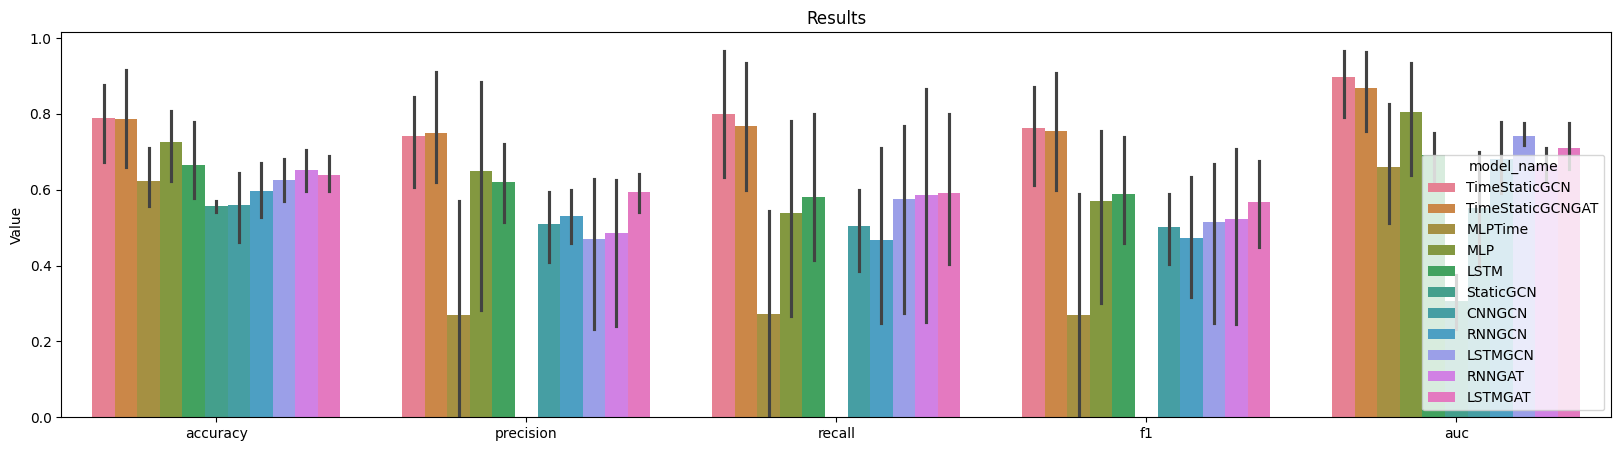

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x = 'metric_name', y = 'value', hue = "model_name", data = results_df, ax = ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('Value')
ax.set_title('Results')
plt.show()

### Visualize what the highest performing model learned

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer

In [ ]:
model_pth = '/content/drive/MyDrive/CS224W Project/data/output/model/'
split_pth = '/content/drive/MyDrive/CS224W Project/data/output/splits/'

model_name = 'TimeStaticGCN'
split_df = pd.read_csv(os.path.join(split_pth, f'{model_name}_splits.csv'))

node_importances = []
for fold in range(1, n_splits + 1):
  pth = os.path.join(model_pth, f'{model_name}_fold{fold}.pth')

  model = TimeStaticGCN(num_nodes, hidden_channels, out_channels)
  model.load_state_dict(torch.load(pth, map_location=torch.device('cpu')))
  model.eval()

  explainer = Explainer(
      model=model,
      algorithm=GNNExplainer(epochs=200),
      explanation_type='model',
      node_mask_type='common_attributes',
      edge_mask_type=None,
      model_config=dict(
          mode='multiclass_classification',
          task_level='graph',
          return_type='raw',
      ),
  )

  print(f"Model '{model_name}' (fold {fold}) loaded successfully from {pth}")

  test_user_indxs = split_df.query("split == 'test' & fold == @fold")['user_indx'].to_list()

  for user_indx in test_user_indxs:
    print(f'User {user_indx}')
    explanation = explainer(dataset[user_indx].x, dataset[user_indx].edge_index, edge_attr = dataset[user_indx].edge_attr)
    node_importances.append(explanation.node_mask.numpy()[0, :])

<ipython-input-73-5ac74890372c>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=torch.device('cpu')))


Model 'TimeStaticGCN' (fold 1) loaded successfully from /content/drive/MyDrive/CS224W Project/data/output/model/TimeStaticGCN_fold1.pth
User 8
User 17
User 18
User 21
User 26
User 27
User 34
User 35
User 40
User 41
User 44
User 55
User 62
User 64
User 70


<ipython-input-73-5ac74890372c>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=torch.device('cpu')))


Model 'TimeStaticGCN' (fold 2) loaded successfully from /content/drive/MyDrive/CS224W Project/data/output/model/TimeStaticGCN_fold2.pth
User 9
User 10
User 11
User 13
User 16
User 19
User 28
User 30
User 36
User 50
User 59
User 60
User 63
User 66
User 68


<ipython-input-73-5ac74890372c>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=torch.device('cpu')))


Model 'TimeStaticGCN' (fold 3) loaded successfully from /content/drive/MyDrive/CS224W Project/data/output/model/TimeStaticGCN_fold3.pth
User 2
User 3
User 6
User 7
User 22
User 23
User 24
User 33
User 39
User 53
User 57
User 61
User 65
User 69


<ipython-input-73-5ac74890372c>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=torch.device('cpu')))


Model 'TimeStaticGCN' (fold 4) loaded successfully from /content/drive/MyDrive/CS224W Project/data/output/model/TimeStaticGCN_fold4.pth
User 1
User 4
User 5
User 14
User 15
User 25
User 29
User 32
User 46
User 47
User 51
User 54
User 58
User 71


<ipython-input-73-5ac74890372c>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=torch.device('cpu')))


Model 'TimeStaticGCN' (fold 5) loaded successfully from /content/drive/MyDrive/CS224W Project/data/output/model/TimeStaticGCN_fold5.pth
User 0
User 12
User 20
User 31
User 37
User 38
User 42
User 43
User 45
User 48
User 49
User 52
User 56
User 67


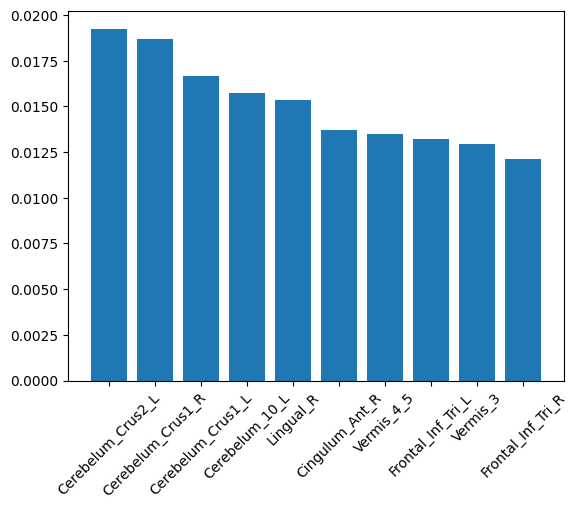

In [ ]:
node_importances = np.array(node_importances)
node_importances /= node_importances.sum(axis=1, keepdims=True)
mean_node_importances = node_importances.mean(axis=0)

with open('/content/aal116NodeNames.txt', 'r') as f:
    node_names = f.read().splitlines()

order_of_importance = np.flip(np.argsort(mean_node_importances))

plt.bar(np.arange(10), mean_node_importances[order_of_importance[:10]])
plt.xticks(np.arange(10), np.array(node_names)[order_of_importance[:10]], rotation=45)
plt.show()

In [ ]:
# open /content/aal116MNI.nii.gz
import nibabel as nib
brain = nib.load("/content/aal116MNI.nii.gz")
img_data = brain.get_fdata()

# open /content/aal116NodeIndex.1D
with open('/content/aal116NodeIndex.1D', 'r') as f:
    node_index = f.read().splitlines()

new_img_data = np.zeros(img_data.shape)
for n in range(116):
  new_img_data[img_data == int(node_index[n])] = mean_node_importances[n]

# save into nii.gz
new_brain = nib.Nifti1Image(new_img_data, brain.affine, brain.header)
nib.save(new_brain, 'new_brain.nii.gz')